# UAV和地面用户管理测试

本notebook用于测试和管理UAV和地面用户的功能。

## 目录
1. 模块导入和设置
2. Ground Users测试
   - 基础功能测试
   - 位置和距离计算测试
   - 吞吐量管理测试
3. UserManager测试
   - 用户生成和管理
   - 固定位置用户测试
   - 吞吐量统计测试
4. UAV测试
   - 基础功能测试
   - 移动和速度控制测试
   - 轨迹记录测试
5. 系统集成测试
   - UAV和用户交互测试
   - 边界条件测试


In [1]:
# 1. 模块导入和设置
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except ImportError:
    print("Warning: seaborn not found, using default matplotlib style")
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# 添加src目录到Python路径
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from environment.users import GroundUser, UserManager
from environment.uav import UAV

# 设置随机种子以保证可重复性
np.random.seed(42)

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


## 2. Ground Users测试

### 2.1 基础功能测试
测试GroundUser类的基本功能，包括：
- 创建用户
- 获取位置
- 计算距离
- 吞吐量记录和统计


In [2]:
def test_ground_user_basic():
    """测试GroundUser的基本功能"""
    print("🧪 测试GroundUser基本功能")
    print("="*50)
    
    # 创建用户
    user1 = GroundUser((10.0, 20.0, 5.0), user_id=1)
    user2 = GroundUser((30.0, 40.0, 0.0), user_id=2)
    
    # 测试位置获取和z坐标强制为0
    print(f"📍 用户1位置: {user1.get_position()}")
    print(f"📍 用户2位置: {user2.get_position()}")
    assert user1.get_position()[2] == 0, "用户z坐标应该为0"
    
    # 测试距离计算
    distance = user1.distance_to(user2.get_position())
    print(f"📏 用户间距离: {distance:.2f} 米")
    expected_distance = np.sqrt((30-10)**2 + (40-20)**2)
    assert abs(distance - expected_distance) < 1e-6, "距离计算错误"
    
    # 测试吞吐量记录
    throughputs = [1.5, 2.3, 1.8, 2.1, 1.9]
    for tp in throughputs:
        user1.add_throughput(tp)
    print(f"📊 用户1吞吐量历史: {user1.throughput_history}")
    print(f"📈 用户1平均吞吐量: {user1.get_average_throughput():.2f}")
    assert abs(user1.get_average_throughput() - np.mean(throughputs)) < 1e-6, "平均吞吐量计算错误"
    
    # 测试吞吐量重置
    user1.reset_throughput_history()
    print(f"🔄 重置后吞吐量历史: {user1.throughput_history}")
    assert len(user1.throughput_history) == 0, "吞吐量历史未正确重置"
    
    print("✅ 基础功能测试通过！\n")

# 运行测试
test_ground_user_basic()


🧪 测试GroundUser基本功能
📍 用户1位置: [10. 20.  0.]
📍 用户2位置: [30. 40.  0.]
📏 用户间距离: 28.28 米
📊 用户1吞吐量历史: [1.5, 2.3, 1.8, 2.1, 1.9]
📈 用户1平均吞吐量: 1.92
🔄 重置后吞吐量历史: []
✅ 基础功能测试通过！



### 2.2 位置和距离可视化测试
测试和可视化用户位置和距离计算：
- 创建多个用户
- 可视化用户位置
- 计算和显示用户间距离


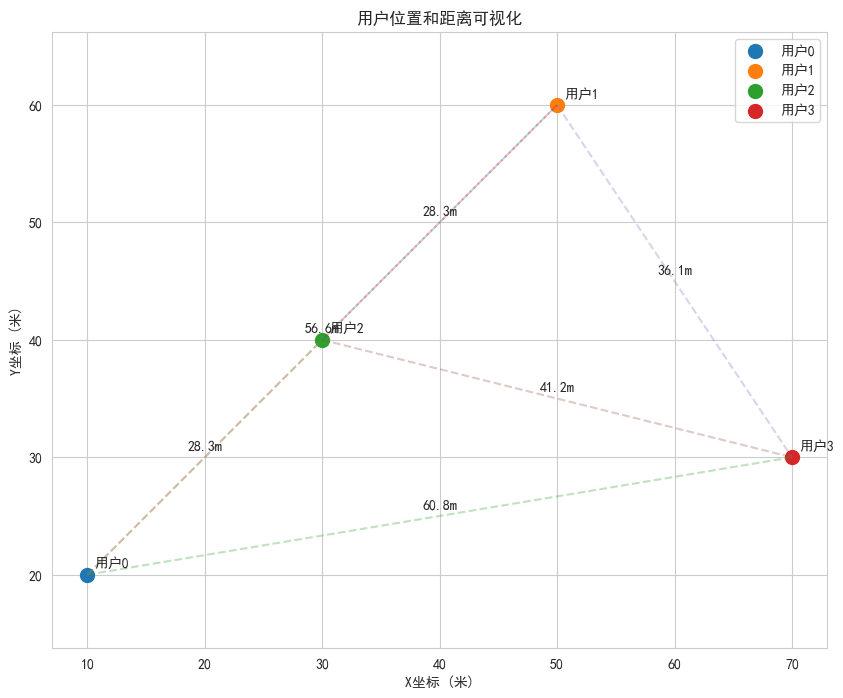

In [3]:
def visualize_users_and_distances():
    """可视化用户位置和距离"""
    # 创建多个用户
    users = [
        GroundUser((10, 20, 0), 0),
        GroundUser((50, 60, 0), 1),
        GroundUser((30, 40, 0), 2),
        GroundUser((70, 30, 0), 3)
    ]
    
    # 创建图形
    plt.figure(figsize=(10, 8))
    
    # 绘制用户位置
    for user in users:
        pos = user.get_position()
        plt.scatter(pos[0], pos[1], s=100, label=f'用户{user.user_id}')
        plt.annotate(f'用户{user.user_id}', (pos[0], pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
    
    # 计算并显示用户间距离
    for i, user1 in enumerate(users):
        for j, user2 in enumerate(users[i+1:], i+1):
            distance = user1.distance_to(user2.get_position())
            mid_x = (user1.position[0] + user2.position[0]) / 2
            mid_y = (user1.position[1] + user2.position[1]) / 2
            plt.plot([user1.position[0], user2.position[0]], 
                    [user1.position[1], user2.position[1]], '--', alpha=0.3)
            plt.annotate(f'{distance:.1f}m', (mid_x, mid_y), 
                        xytext=(0, 5), textcoords='offset points', ha='center')
    
    plt.title('用户位置和距离可视化')
    plt.xlabel('X坐标 (米)')
    plt.ylabel('Y坐标 (米)')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

# 运行可视化
visualize_users_and_distances()


## 3. UserManager测试

### 3.1 用户生成和管理测试
测试UserManager类的功能：
- 随机用户生成
- 固定位置用户设置
- 用户查询和管理
- 吞吐量统计


In [4]:
def test_user_manager():
    """测试UserManager的功能"""
    print("🧪 测试UserManager功能")
    print("="*50)
    
    # 创建UserManager实例
    manager = UserManager(num_users=4)
    
    # 测试随机用户生成
    print("\n📍 测试随机用户生成")
    manager.generate_random_users(x_range=(0, 100), y_range=(0, 100), seed=42)
    positions = manager.get_user_positions()
    print(f"生成的用户位置:\n{positions}")
    assert len(manager.users) == 4, "用户数量不正确"
    
    # 测试固定位置用户设置
    print("\n📌 测试固定位置用户设置")
    fixed_positions = np.array([
        [10, 20, 0],
        [30, 40, 0],
        [50, 60, 0],
        [70, 80, 0]
    ])
    manager.set_fixed_users(fixed_positions)
    new_positions = manager.get_user_positions()
    print(f"设置的固定位置:\n{new_positions}")
    assert np.allclose(new_positions, fixed_positions), "固定位置设置失败"
    
    # 测试用户查询
    print("\n🔍 测试用户查询")
    user = manager.get_user_by_id(2)
    print(f"查询用户2的位置: {user.get_position()}")
    assert np.allclose(user.get_position(), fixed_positions[2]), "用户查询结果错误"
    
    # 测试吞吐量管理
    print("\n📊 测试吞吐量管理")
    throughputs = {
        0: [1.5, 2.0, 1.8],
        1: [2.1, 2.3, 2.2],
        2: [1.9, 1.7, 1.8],
        3: [2.4, 2.2, 2.3]
    }
    
    for user_id, tps in throughputs.items():
        for tp in tps:
            manager.add_throughput_to_user(user_id, tp)
    
    total_throughput = manager.get_total_throughput()
    print(f"总吞吐量: {total_throughput:.2f}")
    
    # 验证总吞吐量
    expected_total = sum(np.mean(tps) for tps in throughputs.values())
    assert abs(total_throughput - expected_total) < 1e-6, "总吞吐量计算错误"
    
    # 测试吞吐量重置
    print("\n🔄 测试吞吐量重置")
    manager.reset_all_throughput_history()
    new_total = manager.get_total_throughput()
    print(f"重置后总吞吐量: {new_total:.2f}")
    assert new_total == 0, "吞吐量重置失败"
    
    # 测试最小距离计算
    print("\n📏 测试最小距离计算")
    test_point = np.array([40, 50, 30])
    min_dist = manager.get_minimum_distance_to_users(test_point)
    print(f"到测试点的最小距离: {min_dist:.2f}米")
    
    print("\n✅ UserManager测试通过！")

# 运行测试
test_user_manager()


🧪 测试UserManager功能

📍 测试随机用户生成
生成的用户位置:
[[37.45401  95.071434  0.      ]
 [73.199394 59.86585   0.      ]
 [15.601864 15.599452  0.      ]
 [ 5.808361 86.617615  0.      ]]

📌 测试固定位置用户设置
设置的固定位置:
[[10. 20.  0.]
 [30. 40.  0.]
 [50. 60.  0.]
 [70. 80.  0.]]

🔍 测试用户查询
查询用户2的位置: [50. 60.  0.]

📊 测试吞吐量管理
总吞吐量: 8.07

🔄 测试吞吐量重置
重置后总吞吐量: 0.00

📏 测试最小距离计算
到测试点的最小距离: 33.17米

✅ UserManager测试通过！


## 4. UAV测试

### 4.1 UAV基础功能测试
测试UAV类的基本功能：
- 初始化和位置设置
- 速度控制
- 边界约束
- 高度维持


In [5]:
def test_uav_basic():
    """测试UAV的基本功能"""
    print("🧪 测试UAV基本功能")
    print("="*50)
    
    # 创建UAV实例
    start_pos = (20, 30, 50)
    uav = UAV(start_position=start_pos,
              num_antennas=8,
              max_speed=30.0,
              min_speed=10.0,
              transmit_power=0.5,
              env_bounds=(100, 100, 100))
    
    # 测试初始化
    print("\n📍 测试初始化")
    print(f"初始位置: {uav.get_position()}")
    print(f"初始速度: {uav.get_velocity()}")
    assert np.allclose(uav.get_position(), start_pos), "初始位置设置错误"
    assert np.allclose(uav.get_velocity(), [0, 0, 0]), "初始速度应为0"
    
    # 测试移动
    print("\n🚁 测试移动")
    direction = np.array([1.0, 0.0])  # 向x轴正方向移动
    speed = 20.0
    uav.move(direction, speed, time_step=1.0)
    new_pos = uav.get_position()
    new_vel = uav.get_velocity()
    print(f"移动后位置: {new_pos}")
    print(f"移动后速度: {new_vel}")
    
    # 验证移动后的位置和速度
    expected_x = start_pos[0] + speed * 1.0  # 1秒后的预期x坐标
    assert abs(new_pos[0] - expected_x) < 1e-6, "x方向移动距离错误"
    assert new_pos[2] == start_pos[2], "高度应该保持不变"
    
    # 测试边界约束
    print("\n🚧 测试边界约束")
    # 尝试移动到边界外
    direction = np.array([1.0, 1.0])
    uav.move(direction, speed * 10, time_step=5.0)  # 大速度，长时间
    constrained_pos = uav.get_position()
    print(f"约束后位置: {constrained_pos}")
    assert all(0 <= p <= b for p, b in zip(constrained_pos, uav.env_bounds)), "位置超出边界"
    
    # 测试速度限制
    print("\n⚡ 测试速度限制")
    # 尝试使用超过最大速度的速度
    direction = np.array([1.0, 0.0])
    uav.move(direction, uav.max_speed * 2, time_step=1.0)
    limited_vel = uav.get_velocity()
    print(f"限制后速度: {limited_vel}")
    assert np.linalg.norm(limited_vel[:2]) <= uav.max_speed, "速度超过最大限制"
    
    # 测试重置
    print("\n🔄 测试重置")
    uav.reset()
    reset_pos = uav.get_position()
    reset_vel = uav.get_velocity()
    print(f"重置后位置: {reset_pos}")
    print(f"重置后速度: {reset_vel}")
    assert np.allclose(reset_vel, [0, 0, 0]), "重置后速度应为0"
    assert reset_pos[2] == start_pos[2], "重置后高度应保持不变"
    
    print("\n✅ UAV基本功能测试通过！")

# 运行测试
test_uav_basic()


🧪 测试UAV基本功能

📍 测试初始化
初始位置: [20. 30. 50.]
初始速度: [0. 0. 0.]

🚁 测试移动
移动后位置: [40. 30. 50.]
移动后速度: [20.  0.  0.]

🚧 测试边界约束
约束后位置: [100. 100.  50.]

⚡ 测试速度限制
限制后速度: [30.  0.  0.]

🔄 测试重置
重置后位置: [ 0.  0. 50.]
重置后速度: [0. 0. 0.]

✅ UAV基本功能测试通过！


### 4.2 UAV轨迹测试和可视化
测试UAV的轨迹记录和可视化：
- 模拟UAV移动轨迹
- 记录位置历史
- 轨迹可视化


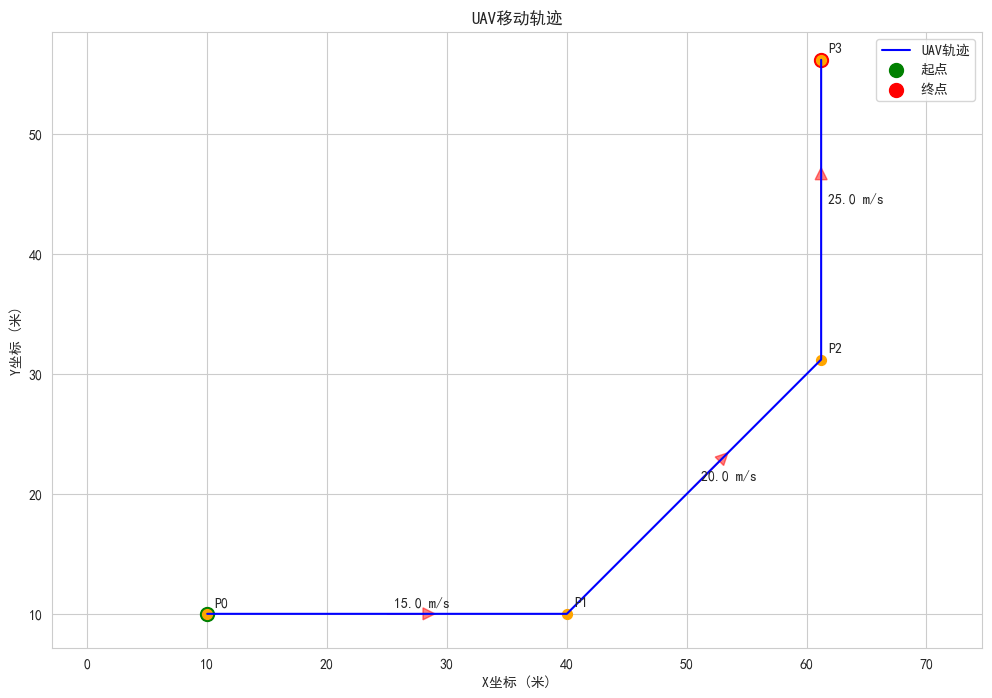


📊 轨迹统计信息:
段0: 距离 = 30.00m, 速度 = 15.0m/s, 时间 = 2.0s
段1: 距离 = 30.00m, 速度 = 20.0m/s, 时间 = 1.5s
段2: 距离 = 25.00m, 速度 = 25.0m/s, 时间 = 1.0s
总距离: 85.00m


In [6]:
def test_uav_trajectory():
    """测试UAV轨迹记录和可视化"""
    # 创建UAV实例
    uav = UAV(start_position=(10, 10, 50),
              num_antennas=8,
              max_speed=30.0,
              min_speed=10.0,
              env_bounds=(100, 100, 100))
    
    # 模拟UAV移动路径
    # 1. 向右移动
    direction1 = np.array([1.0, 0.0])
    # 2. 向右上移动
    direction2 = np.array([1.0, 1.0])
    # 3. 向上移动
    direction3 = np.array([0.0, 1.0])
    
    # 执行移动
    speeds = [15.0, 20.0, 25.0]
    time_steps = [2.0, 1.5, 1.0]
    directions = [direction1, direction2, direction3]
    
    plt.figure(figsize=(12, 8))
    
    # 记录每次移动后的位置
    positions = [uav.get_position()]
    for direction, speed, time_step in zip(directions, speeds, time_steps):
        uav.move(direction, speed, time_step)
        positions.append(uav.get_position())
    
    # 获取完整轨迹
    trajectory = uav.get_trajectory()
    
    # 绘制轨迹
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label='UAV轨迹')
    
    # 标记起点和终点
    plt.scatter(trajectory[0, 0], trajectory[0, 1], c='g', s=100, label='起点')
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='r', s=100, label='终点')
    
    # 添加移动点标记
    for i, pos in enumerate(positions):
        plt.scatter(pos[0], pos[1], c='orange', s=50)
        plt.annotate(f'P{i}', (pos[0], pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
    
    # 添加速度向量
    for i in range(len(positions)-1):
        mid_x = (positions[i][0] + positions[i+1][0]) / 2
        mid_y = (positions[i][1] + positions[i+1][1]) / 2
        dx = positions[i+1][0] - positions[i][0]
        dy = positions[i+1][1] - positions[i][1]
        plt.arrow(mid_x, mid_y, dx/10, dy/10, 
                 head_width=1, head_length=1, fc='red', ec='red', alpha=0.5)
        speed_text = f'{speeds[i]:.1f} m/s'
        plt.annotate(speed_text, (mid_x, mid_y), 
                    xytext=(5, 5), textcoords='offset points')
    
    plt.title('UAV移动轨迹')
    plt.xlabel('X坐标 (米)')
    plt.ylabel('Y坐标 (米)')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()
    
    # 打印轨迹信息
    print("\n📊 轨迹统计信息:")
    total_distance = 0
    for i in range(len(positions)-1):
        distance = np.linalg.norm(positions[i+1][:2] - positions[i][:2])
        print(f"段{i}: 距离 = {distance:.2f}m, 速度 = {speeds[i]:.1f}m/s, 时间 = {time_steps[i]:.1f}s")
        total_distance += distance
    print(f"总距离: {total_distance:.2f}m")

# 运行测试
test_uav_trajectory()


## 5. 系统集成测试

### 5.1 UAV和用户交互测试
测试UAV和用户之间的交互：
- UAV对用户的覆盖
- 距离计算
- 轨迹规划


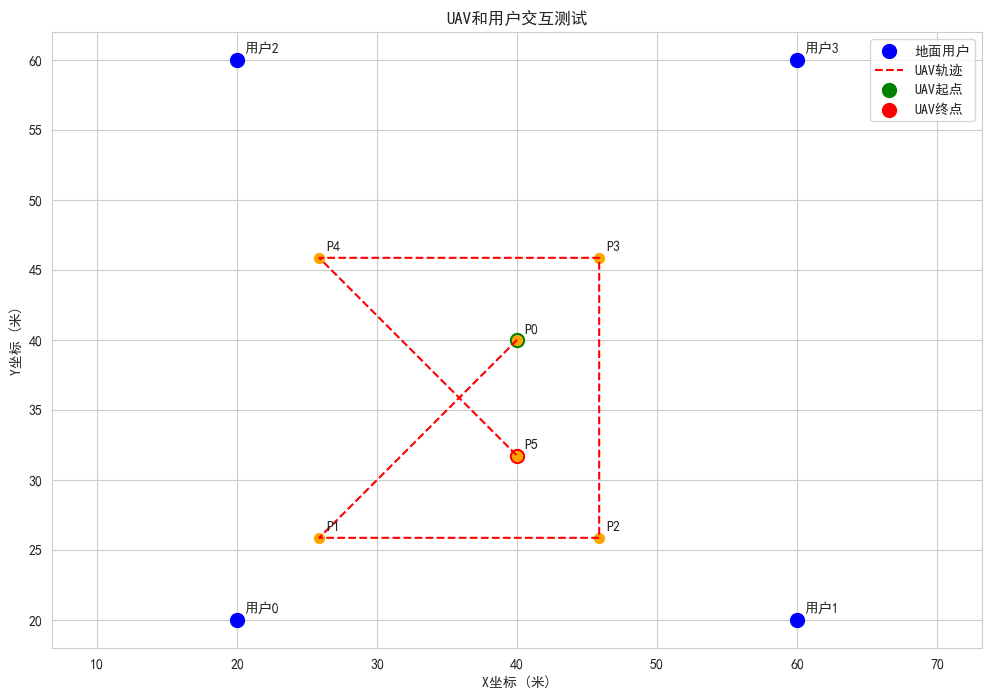


📊 UAV到用户的距离统计:

位置P0:
  起始点
  起始点
  起始点
  起始点

位置P1:
  到用户0的距离: 50.68m
  到用户1的距离: 60.83m
  到用户2的距离: 60.83m
  到用户3的距离: 69.51m

位置P2:
  到用户0的距离: 56.59m
  到用户1的距离: 52.29m
  到用户2的距离: 65.84m
  到用户3的距离: 62.17m

位置P3:
  到用户0的距离: 61.95m
  到用户1的距离: 58.04m
  到用户2的距离: 58.04m
  到用户3的距离: 53.85m

位置P4:
  到用户0的距离: 56.59m
  到用户1的距离: 65.84m
  到用户2的距离: 52.29m
  到用户3的距离: 62.17m

位置P5:
  到用户0的距离: 55.11m
  到用户1的距离: 55.11m
  到用户2的距离: 60.83m
  到用户3的距离: 60.83m

📡 覆盖分析:
位置P1: 覆盖 0 个用户
位置P2: 覆盖 0 个用户
位置P3: 覆盖 0 个用户
位置P4: 覆盖 0 个用户
位置P5: 覆盖 0 个用户


In [7]:
def test_uav_user_interaction():
    """测试UAV和用户的交互"""
    # 创建用户管理器和UAV
    user_manager = UserManager(num_users=4)
    fixed_positions = np.array([
        [20, 20, 0],
        [60, 20, 0],
        [20, 60, 0],
        [60, 60, 0]
    ])
    user_manager.set_fixed_users(fixed_positions)
    
    uav = UAV(start_position=(40, 40, 50),
              num_antennas=8,
              max_speed=30.0,
              min_speed=10.0,
              env_bounds=(100, 100, 100))
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 绘制用户位置
    user_positions = user_manager.get_user_positions()
    plt.scatter(user_positions[:, 0], user_positions[:, 1], 
                c='blue', s=100, label='地面用户')
    for i, pos in enumerate(user_positions):
        plt.annotate(f'用户{i}', (pos[0], pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
    
    # 模拟UAV移动并记录轨迹
    # 1. 访问用户0
    direction1 = np.array([20-40, 20-40])  # 向用户0移动
    # 2. 访问用户1
    direction2 = np.array([60-20, 0])      # 向用户1移动
    # 3. 访问用户3
    direction3 = np.array([0, 60-20])      # 向用户3移动
    # 4. 访问用户2
    direction4 = np.array([-40, 0])        # 向用户2移动
    # 5. 返回中心
    direction5 = np.array([40-20, 40-60])  # 返回中心
    
    directions = [direction1, direction2, direction3, direction4, direction5]
    speeds = [20.0] * len(directions)
    time_steps = [1.0] * len(directions)
    
    # 记录轨迹点
    trajectory_points = [uav.get_position()]
    distances_to_users = []
    
    # 执行移动并记录数据
    for i, (direction, speed, time_step) in enumerate(zip(directions, speeds, time_steps)):
        # 标准化方向向量
        if np.linalg.norm(direction) > 0:
            direction = direction / np.linalg.norm(direction)
        
        # 移动UAV
        uav.move(direction, speed, time_step)
        current_pos = uav.get_position()
        trajectory_points.append(current_pos)
        
        # 计算到所有用户的距离
        distances = [user.distance_to(current_pos) for user in user_manager.users]
        distances_to_users.append(distances)
    
    # 绘制UAV轨迹
    trajectory = np.array(trajectory_points)
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'r--', label='UAV轨迹')
    plt.scatter(trajectory[0, 0], trajectory[0, 1], c='g', s=100, label='UAV起点')
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='r', s=100, label='UAV终点')
    
    # 添加轨迹点标记
    for i, pos in enumerate(trajectory_points):
        plt.scatter(pos[0], pos[1], c='orange', s=50)
        plt.annotate(f'P{i}', (pos[0], pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
    
    plt.title('UAV和用户交互测试')
    plt.xlabel('X坐标 (米)')
    plt.ylabel('Y坐标 (米)')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()
    
    # 打印距离信息
    print("\n📊 UAV到用户的距离统计:")
    distances_to_users = np.array(distances_to_users)
    for i in range(len(trajectory_points)):
        print(f"\n位置P{i}:")
        for j in range(len(user_manager.users)):
            print(f"  到用户{j}的距离: {distances_to_users[i-1][j]:.2f}m" if i > 0 else "  起始点")
    
    # 计算覆盖统计
    coverage_radius = 40  # 假设UAV的覆盖半径为40米
    print("\n📡 覆盖分析:")
    for i in range(len(trajectory_points)):
        if i == 0:
            continue
        covered_users = sum(d <= coverage_radius for d in distances_to_users[i-1])
        print(f"位置P{i}: 覆盖 {covered_users} 个用户")

# 运行测试
test_uav_user_interaction()
